Written by Mohammad Hesam Soleimani-Babakamali
soleimanihesam92@vt.edu

#Required libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM

#plot size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
import math
import time
from random import shuffle
import matplotlib.pyplot as plt
import pickle
!pip install mat73
import mat73

## Tensors to be Float or Double is important, as for $S_{GAN}$ scores, as Floats cannot capture values less than 10^-40 (max $S_{GAN}$ of 40). If you have enough GPU, go for the Double; otherwise, Float.

In [2]:
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## The code automatically creates a folder with the name of Folder_N's string that you define below. Several subfolders to save different analysis results are also made there.

## This code is for the public QUGS dataset A, available at http://onur-avci.com/benchmark/download/.

## After the base folder is made, please copy-paste the mat files $C_L$ and $F_I$ into it. $F_I$ is the $F_I$ feature of the 11 data classes, and $C_L$ is an array of data class lengths based on $D_L$. They are MATLAB ".mat" files.

## With $D_L=1000$, and for the 2-sensor-based QUGS, $F_I$ is of size 1000X1, and $C_L$ is a fixed array of 262.

## The following code creates 11 subfolders of DC1 to DC11 for the eleven data classes under the "LSTM" folder. We have an LSTM network for this code; thus, that name is selected.

In [20]:
from os import path
Folder_N='TEST'
Folder_Path=os.path.join('/content/drive/MyDrive/'+Folder_N)
if (not os.path.exists(os.path.join('/content/drive/MyDrive/'+Folder_N))):
  os.mkdir(os.path.join('/content/drive/MyDrive/'+Folder_N))
  os.mkdir(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM'))
  for i in range(11):
   os.mkdir(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)))

# Loading the m.mat files

## The F_I.mat should be saved in MATLAB as v7.3 and should have the following name and data type (a simple double file):
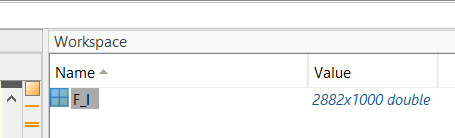

## 2882 is for 11 classes, each of size 262. This dimension shows how a user must concatenate data to work with this code.
## C_L.mat should also be a simple array:

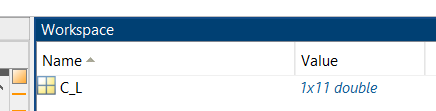

In [21]:
path=os.path.join('/content/drive/MyDrive/'+Folder_N+'/F_I.mat')
data_dict = mat73.loadmat(path)
path3=os.path.join('/content/drive/MyDrive/'+Folder_N+'/C_L.mat')
data_dict2 = mat73.loadmat(path3)
C_N=np.array(data_dict2["zet"])
E1=np.cumsum(C_N)
Max=len(data_dict)
DM=np.array(data_dict["C"])
R=DM.shape
R1=np.arange(1,R[1]+1)
plt.plot(R1,DM[1,:])
plt.title('A samle data instance',fontsize=36)
plt.xlabel('Concatenated Dimension',fontsize=24)
plt.ylabel('$F_I$',fontsize=24);

AssertionError: ignored

# Custom LSTM-based D

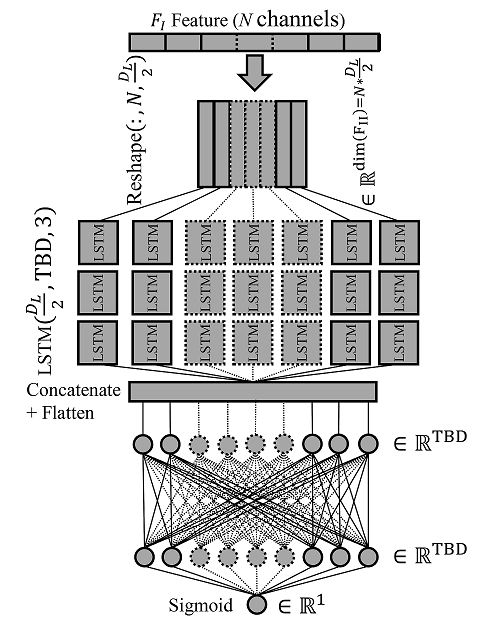

In [22]:
# LSTM-based D
class LSTM_Net_2(nn.Module):
    def __init__(self):
        super().__init__()
        super(LSTM_Net_2, self).__init__()
        input_dim = 500
        hidden_dim = 10
        n_layers = 1
        batch_size = 2
        seq_len = 1
        SL=3
        self.lstm1 = nn.LSTM(500, 100, SL, batch_first=True)
        self.lstm2 = nn.LSTM(500, 100, SL, batch_first=True)
        self.Flatten = nn.Flatten()
        self.FC1=nn.Linear(200,100)
        self.FC2=nn.Linear(100,1)
        self.Sig=nn.Sigmoid()

    def forward(self, x):

        out1,state = self.lstm1(x[:,:,0:500])
        out2,state = self.lstm2(x[:,:,500:1000])
        LL=torch.cat((out1,out2),dim=2)
        out11=self.Flatten(LL)
        outNF=self.FC1(out11)
        outF=self.FC2(outNF)
        outFF=self.Sig(outF)
        return outFF
    
def generator(noise_dim):
    model = nn.Sequential(
        nn.Linear(noise_dim,256),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.BatchNorm1d(256, affine=False),
        nn.Linear(256,512),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.BatchNorm1d(512, affine=False),
        nn.Linear(512,656),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.BatchNorm1d(656, affine=False),
        nn.Linear(656,1000),
        nn.ReLU(inplace=True),
    )
    return model

# D and G loss functions
## The added epsilon is to avoid non-definite values

In [23]:
def discriminator_loss(logits_real, logits_fake):
    eps=0.00000000000000000000000000001
    true_labels = torch.ones(logits_real.size(),device=device)
    loss =-1*torch.mean(torch.log10(logits_real+eps)+torch.log10(1-logits_fake+eps))
    return loss

def generator_loss(logits_fake):
    eps=0.00000000000000000000000000001
    true_labels = torch.ones(logits_fake.size(),device=device)
    loss=-1*torch.mean(torch.log10(logits_fake+eps))
    return loss

# GAN training function

## A simple "For" loop to train GAN.
## Be aware of dimensions while using this code for other datasets and sensors. 


In [24]:
from tqdm import tqdm

def sample_noise(batch_size, dim):
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)

# D is the Discriminator architecture  
# G is the Generator architecture  
# D_solver is the optimizer for D  
# G_solver is the optimizer for G
# discriminator_loss is the loss function of D
# generator_loss is the loss function of G
# show_every dictates at how many epochs the network to be saved, but loss functions, W, and WW are reported for all epochs as the return function  

def trainLSTM(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=10, 
          cont_train=False,
          batch_size=100, noise_size=100, num_epochs=30, train_loader=None, device=None,D_C=None):
     inner_bar = tqdm(range(num_epochs), desc = 'Epochs:\t', leave = True, position=0)
     iter_count = 0
     WW=np.array([])
     WW1=np.array([])   
     for epoch in range(num_epochs):
        inner_bar.update(1)
        for jj in range(1):


            real_images = np.reshape(train_loader.detach().cpu().numpy(),(100,1,1000))
            real_images=torch.Tensor(real_images)
            d_error = None
            g_error = None
            fake_images = None
            D_solver.zero_grad()
            random_noise = sample_noise(batch_size, noise_size).to(device)
            random_noise = random_noise/torch.max(random_noise)
            fake_images = G(random_noise)
            disc_fake = D.forward(fake_images.reshape(batch_size,1,1000))
            disc_real = D(real_images)
            d_error = discriminator_loss(disc_real, disc_fake)
            dd=d_error.detach().cpu()
            dd=dd.numpy()
            WW1=np.append(WW1,dd)
            d_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            random_noise = torch.randn((batch_size, noise_size), device=device)
            random_noise = random_noise/torch.max(random_noise)
            fake_images = G(random_noise)
            disc_fake = D.forward(fake_images.reshape(batch_size,1,1000))
            g_error = generator_loss(disc_fake)
            gg=g_error.detach().cpu()
            gg=gg.numpy()
            WW=np.append(WW,gg)
            g_error.backward()
            G_solver.step()

            iter_count += 1
            if (iter_count % show_every == 0):
                torch.save({'epoch': epoch, 
                    'iter_count': iter_count,
                    'G': G.state_dict(), 
                    'D': D.state_dict()}, 
                    os.path.join(Folder_Path+'/LSTM/DC'+str(D_C)+'/'+str(epoch)+'checkpoint.pth'))
     return WW,WW1

## Training GAN and saving the losses "Pickle" file and also an image of losses
### Training is taking place for only the TL ($T_L$) of each data class


In [ ]:
# i from 0 to 11 indicates training GAN for all 11 classes

for i in range(0,11):
  print('Data class '+str(i+1),'\n')
  TL=100;
  Epoch=20000;
  batch_size = TL
  if i==0:
     H=DM[0:TL,:]
  else:
     H=DM[int(E1[i-1]):TL+int(E1[i-1])]
  HT = torch.from_numpy(H)
  HT=HT.cpu()
  HT=torch.tensor(HT, device=device)
  HT=torch.reshape(HT,(100,1,1000))
  HT=HT.float()
  D = LSTM_Net_2().to(device)
  G = generator(100).to(device)
  D_solver = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999))
  G_solver = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))
  [Y,YY]=trainLSTM(D, G, D_solver, G_solver, discriminator_loss, generator_loss,train_loader=HT, device=device,batch_size=100, noise_size=100,num_epochs=Epoch,show_every=250,D_C=i+1)
  UU=np.array([Y ,YY])

# Saving loss values
  AD=os.path.join(Folder_Path+'/LSTM/DC'+str(i+1)+'/')
  filename2=os.path.join(AD+'Loss.pik') 
  with open(filename2, 'wb') as f:
    pickle.dump(UU,f)
  plt.plot(Y)
  plt.plot(YY)
  plt.legend({'G loss','D loss'})
  plt.ylim(0,5)
  plt.xlim(0,Epoch)

#Save plots of D-G losses
  plt.savefig(os.path.join(AD+'Loss.png'))
  plt.show()

# Algorithm 1
## Algorithm 1 is modified to accept a reliability $\beta$ as well, the same as our arXiv paper. It can be turned off at will.

In [27]:
def Two_GMM(Hist,Bin,bins,Reliability=True):
  bi=np.zeros((sum(Hist), 1))
  C_N=0
  for i in range(len(Hist)):
   for j in range(int(Hist[i])):
     bi[C_N]=Bin[i]
     C_N=C_N+1
  for i in range(1):
    gm = GMM(covariance_type='diag',n_components=2, random_state=0).fit(bi)
    EEE=gm.predict(bi)
    Pet=gm.means_  
    if np.max(bi[EEE==1])>np.max(bi[EEE==0]):
      M0=Pet[0]
      M1=Pet[1]
      N=0;
      bi0=bi[EEE==0]
      std0=np.std(bi0)
      bi1=bi[EEE==1]
      std1=np.std(bi1)
    else:
      N=1;
      M1=Pet[0]
      M0=Pet[1]
      bi0=bi[EEE==1]
      bi1=bi[EEE==0]
      std0=np.std(bi0)
      std1=np.std(bi1)
    STD=np.std(bi1)
    if(M1-M0)>(3*std0):
      bi1=bi[bi<=(M0+3*std0)]
    else:
      bi1=bi
    heights, bin_bounds = np.histogram(bi1, bins)
    if(Reliability):
      J=np.cumsum(heights)
      J=J/np.max(J)
      # Beta(3.5)=0.999767424999515
      J=J-0.999767424999515
      N=0
      for i in range(len(J)-1):
        if J[i]<0:
            N=i-1
      print(N)
      heights[N+1::]=0
  return heights


# This is an important part of the code

## Per the paper, three different epochs are selected regarding various loss patterns. Based on pattern definitions, users must track G-D losses. Both an image and a .pik file are saved for each data class in their directory, aiding users to select their desired epochs. A sample is shown here.

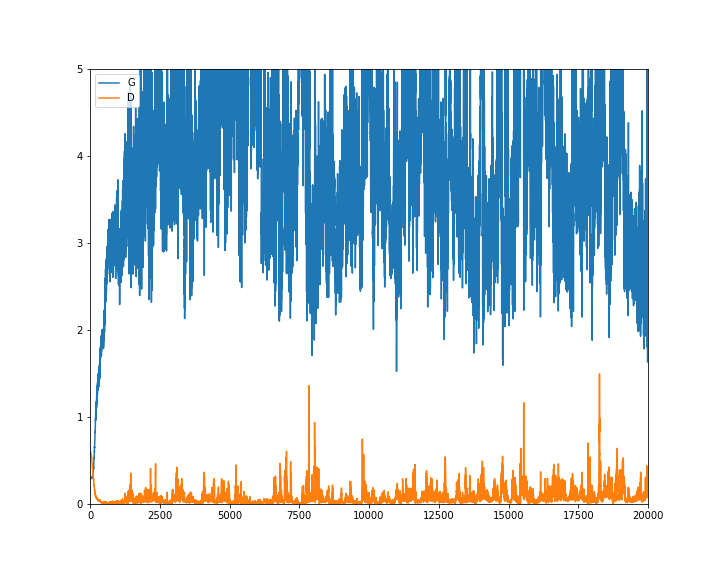


## Here, a set of predefined epochs of 10000, 12500, and 15000 is selected from the 20000 available ones.

## the parameter "key" is the array's name storing the epochs for all data classes. For instance, in the following code, that array is named "Range", and the key is designated as "Range" accordingly.

## The selected epochs are only for the sake of executing the code. For the case of overfitted $D$, i.e., the discriminator conquered loss pattern for LSTM, users must select epochs with near-zero $S_{GAN}$ while avoiding "I points", as described in the paper. 


## The following code defines $T_1$ based on Algorithm 1 of the paper and for the selected epochs.

In [ ]:
key='Range'
Folder_N='TEST'

Range=np.array([[10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000]])

Folder_Path=os.path.join('/content/drive/MyDrive/'+Folder_N)
for i in range(11):
  if (not os.path.exists(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+key))):
    os.mkdir(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+key))

# Bin spacing
Bin_S=0.01

# Number of samples, n
n=50000

# VL
V_L=10

for i in range(11):
  for j in range(3):
    str1='Epoch='+key+'[%s,%s]'
    exec(str1 %(i,j))
    D=LSTM_Net_2()
    G=generator(100)
    checkpoint =torch.load(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+str(Epoch-1)+'checkpoint.pth'))
    D.load_state_dict(checkpoint['D'])
    G.load_state_dict(checkpoint['G'])
    del checkpoint 
    torch.cuda.empty_cache()
    random_noise = sample_noise(n, 100).to(device)
    fake_images = G(random_noise)
    del random_noise
    torch.cuda.empty_cache()
    fake_images=fake_images.detach().cpu()
    fake_images=fake_images.numpy()
    fake_images=fake_images.reshape(n,1,1000)
    fake_images=torch.Tensor(fake_images)
    Q=(D(fake_images))
    del fake_images
    torch.cuda.empty_cache()
    Q=torch.squeeze(Q)
    Q=Q.reshape(n,1)
    [A,B]=Q.shape
    A=np.array(A)
    B=math.floor(A/V_L)
    Q=Q[0:n,:]
    Q=Q.view(V_L,B,1)
    del G,D
    torch.cuda.empty_cache()
    ## GAN scores
    QQ=Q.detach().cpu().numpy()
    QQ=-np.log10(QQ+1e-80)
    R11=[np.percentile(QQ[:,l],50) for l in range(int(A/V_L))]
    R11=np.array(R11)
    bins=np.arange(0,80,Bin_S)
    heights, bin_bounds = np.histogram(R11, bins)
    binsA=np.arange(0,80-Bin_S,Bin_S)
    plt.plot(binsA,heights)
    bins2=np.arange(0,80-Bin_S,Bin_S)
    # Reliability can be set to true or false
    heights1=Two_GMM(heights,bins2,bins,Reliability=True)
    plt.plot(bins2,heights1)
    A=len(heights1)
    enum=1
    while(heights1[A-enum]==0):
      enum+=1
    bins2=np.arange(0,80-Bin_S,Bin_S)
    T80=bins2[A-enum]
    plt.xlim(0,min(2*T80,40))
    plt.ylabel('$T_1$')
    plt.legend(['$G_2$','$G_1+G_2$'])
    plt.show()
    print('T1 is equal to:',T80)
    AD=os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+key+'/')
    filename2=os.path.join(AD+'T1_'+str(j+1)+'.pik') 
    with open(filename2, 'wb') as f:
      pickle.dump(T80,f)
    torch.cuda.empty_cache()
    del R11,bins,bins2
    torch.cuda.empty_cache()



### As mentioned in the paper, permutation detection of various Epochs embodies billions of thousands of detection instances. All detections are performed in a matrix-based format to enable such a comprehensive detection. We had GAN of all classes trained on their training length before to have the trained GANs and thresholds called whenever a novelty occurs. That reduces the time burden heavily. The burden is further reduced by having $S_{GAN} of the whole dataset for each epoch and GAN of each data class. The process is taking place here.
 
### For each epoch and each data class (GAN), an array of $S_{GAN}$ is built. Then, an array of $T_1$, with the same dimension as $S_{GAN}$ is created. Those arrays are saved in DATA1, DATA2, and DATA3.pk for three epochs of each data class.
 
### It is worth mentioning that all classes are trimmed to have $V_L$  dividing their length. By doing so, a matrix-based accuracy estimation became possible. For instance, if a class has 1001 data instances with $V_L$ of 100, the last data point is dropped.


In [29]:
## NEW Numbers
V_L=10
C_N=(np.ones((11,1))*np.floor(262/V_L)*V_L).reshape((1,-1))
C_N=C_N[0]
DM=np.array(data_dict["C"])
DMP=np.zeros((int(C_N[0])*11,1000))


for i in range(11):
  if(i==0):
    DMP[i*int(C_N[0]):int((i+1)*C_N[0]),:]=DM[0:int((1)*C_N[0]),:]
  if(i>0):
    DMP[i*int(C_N[0]):int((i+1)*C_N[0]),:]=DM[int((i)*262):int((i)*262+(1)*C_N[0]),:]
DM=DMP

Range=np.array([[10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000],
                       [10000,12500,15000]])

Class_L=np.cumsum(C_N)/V_L
WWW=100000
GL=100
C_N=0
Max=len(data_dict)
L=len(DM)
for i in range(11):
  for j in range(3):
    str1='Epoch='+key+'[%s,%s]'
    exec(str1 %(i,j))
    D=LSTM_Net_2()
    G=generator(100)
    checkpoint =torch.load(os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+str(Epoch-1)+'checkpoint.pth'))
    D.load_state_dict(checkpoint['D'])
    AD=os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+key+'/')
    filename2=os.path.join(AD+'T1_'+str(j+1)+'.pik') 
    with open(filename2, 'rb') as f:
      thresholds=pickle.load(f)

    D.load_state_dict(checkpoint['D'])
    M=np.asarray(DM)
    AS1=torch.Tensor(np.reshape(DM,(len(DM),1,1000)))
    PIKO=-torch.log10(D(AS1)+1e-40).detach().cpu().numpy().copy()
    PIKO.resize((int(np.floor(len(DM)/V_L)),V_L))

    # 50th precentiles of F_I scores
    Zinko=np.percentile(PIKO,50,axis=1)
    [A]=Zinko.shape
    MT=np.ones((A,1))
    GAN_S1=Zinko
    GAN_S1=np.asarray(GAN_S1)
    T80_S1=np.reshape(MT*thresholds,(len(MT)))
    T80_S1=np.asarray(T80_S1)
    ALL_D=np.array([GAN_S1,T80_S1])
    AD=os.path.join('/content/drive/MyDrive/'+Folder_N+'/LSTM/DC'+str(i+1)+'/'+key+'/')
    filename2=os.path.join(AD+'DATA'+str(j+1)+'.pik') 
    with open(filename2, 'wb') as f:
      pickle.dump(ALL_D,f)



# Please continue with the Accuracy_Evaluation notebook